In [230]:
import numpy as np
import george
from george import kernels
from scipy.optimize import minimize
from time import time
import argparse
import pickle
import matplotlib.pyplot as plt

In [231]:
def orig_to_trans(pars):
    gamma=pars[6]
    logM_env=pars[8]
    beta=pars[7]
    incl=pars[14]
    
    pars[6]=np.log10(2.1-1*gamma)
    pars[8]=np.log10(-1.5-1*logM_env)
    
    s=np.sin(0.7)
    c=np.cos(0.7)
    
    pars[7]=1-np.cos(((beta*c) + (incl*s/60)-.5)*np.pi/2)
    pars[14]=(-beta*s) + (incl*c/60)
    return pars

def trans_to_orig(pars):
    gamma_trans=pars[6]
    logM_env_trans=pars[8]
    bi_x=pars[7]
    bi_y=pars[14]
    
    pars[6]=2.1 - 10**gamma_trans
    pars[8]=-1.5 - 10**logM_env_trans
    
    s=np.sin(0.7)
    c=np.cos(0.7)
    
    pars[7]=round((1/(c+(s**2/c)))*((2/np.pi)*np.arccos(1-bi_x)+0.5-(s/c)*bi_y),14)
    pars[14]=round((60*s)*((2/np.pi)*np.arccos(1-bi_x)+0.5+(c/s)*bi_y),14)
    return pars

In [233]:
with open ('./gmd/cubefull.txt', 'rb') as fp:
    old_grid = np.array(pickle.load(fp))
param_names = ["Tstar","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]
    
xvals=np.load("./etgrid/xvals.npy")
orig_dict=np.load("./gmd/dictionary.npy",allow_pickle=True)

def point(i):
    coords=[]
    for j in param_names:
        coords.append(orig_dict[i][j])
    transcoords=orig_to_trans(coords)
    sed = old_grid[i][100:500]
    return (transcoords, sed)

In [237]:
sample=np.random.randint(0,3850,10)
sample_coords=[]
for i in range(len(sample)):
    sample_coords.append(point(sample[i])[0])

In [234]:
#parser=argparse.ArgumentParser()
#parser.add_argument("--name", help="name of pca instance",type=str)
#name = parser.parse_args().name

name = "cobyla"
inst = "3917"
print(np.load("./etgrid/"+inst+"_"+name+"_time_rec.npy")/86400,"days")

fit=np.load("./etgrid/"+inst+"_"+name+"_optimize_result.npy")

1.68242471376227 days


In [235]:
coords=np.load("./etgrid/"+inst+"_coords.npy")
eigenseds=np.load("./etgrid/"+inst+"_eigenseds.npy")
weights=np.load("./etgrid/"+inst+"_weights.npy")
pcamean=np.load("./etgrid/"+inst+"_mean.npy")

yerrs=[]
for i in range(16):
    yerrs.append([x*0.01 for x in weights[i]])


In [236]:
kernel = 16*kernels.ExpSquaredKernel(15**2,ndim=15,axes=0)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=1)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=2)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=3)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=4)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=5)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=6)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=7)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=8)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=9)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=10)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=11)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=12)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=13)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=14) 
blankhodlr=george.GP(kernel)

In [239]:
def pred(pred_coords):
    gp=blankhodlr
    preds=[]
    if "cobyla" in name:
        hyperparams=np.transpose(np.array(fit).reshape(16,16))
    else:
        hyperparams=np.array(fit).reshape(16,16)

    for i in range(len(weights)):  # same covfunc for each weight and the sample mean
        gp.set_parameter_vector(hyperparams[i])
        gp.compute(coords,yerrs[i])
        pred, pred_var = gp.predict(weights[i], pred_coords, return_var=True)
        preds.append(pred)
    reconst_SEDs=[]
    for i in range(len(pred_coords)):
        reconst=np.dot(np.array(preds)[:,i][0:15],eigenseds[0:15]) + pcamean + np.array(preds)[:,i][15]
        reconst_SEDs.append(reconst)
    return reconst_SEDs, preds


In [240]:
predicted_SEDs, predicted_weights =pred(sample_coords)

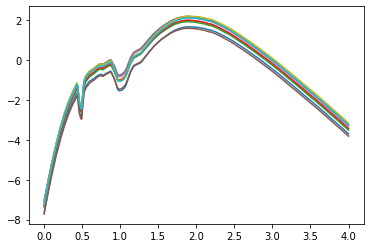

In [241]:
for i in range(len(predicted_SEDs)):
    plt.plot(np.log10(xvals),predicted_SEDs[i])

3035
{'Tstar': 3310.4191529902787, 'logL_star': 0.3236529643764239, 'logM_disk': -3.8892682631005675, 'logR_disk': 2.1362036735378167, 'h_0': 0.019814595059915077, 'logR_in': 1.3517395765762807, 'gamma': 0.9261764529204987, 'beta': 1.130477996940503, 'logM_env': -5.016415160052276, 'logR_env': 3.7338016954255218, 'f_cav': 0.3109596562537101, 'ksi': 1.107314986731303, 'loga_max': 3.0807246619764155, 'p': 3.303266231332603, 'incl': 43.51530520716323, 'filename': 'Tstar_3310.419_logLstar_0.324_logMdisk_-3.9_logRdisk_2.136_h0_0.020_logRin_1.352_gamma_0.926_beta_1.130_logMenv_-5.016_logRenv_3.734_fcav_0.311_ksi_1.107_logamax_3.081_p_3.303_incl_43.515.hdf5'}


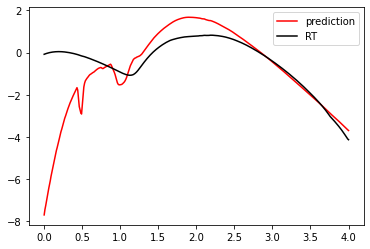

1030
{'Tstar': 3445.2556639391055, 'logL_star': -0.5970952802020991, 'logM_disk': -7.5362154972579996, 'logR_disk': 1.0910425510531816, 'h_0': 0.06669526625836954, 'logR_in': -0.1600353429930511, 'gamma': 1.9412842563101382, 'beta': 1.2694593330073458, 'logM_env': -7.923380116135761, 'logR_env': 3.464361882101902, 'f_cav': 0.2620079115280186, 'ksi': 1.4433287327959463, 'loga_max': 3.7709919505653557, 'p': 4.075323158821552, 'incl': 21.316430905945637, 'filename': 'Tstar_3445.256_logLstar_-0.597_logMdisk_-7.536_logRdisk_1.091_h0_0.067_logRin_-0.160_gamma_1.941_beta_1.269_logMenv_-7.923_logRenv_3.464_fcav_0.262_ksi_1.443_logamax_3.771_p_4.075_incl_21.316.hdf5'}


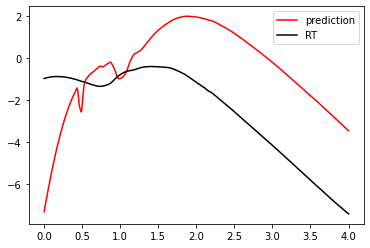

2215
{'Tstar': 3847.6793473453135, 'logL_star': -0.7836375063079919, 'logM_disk': -2.9578509161894395, 'logR_disk': 0.9966973923213314, 'h_0': 0.3156742212148169, 'logR_in': 0.8870078760204545, 'gamma': 1.8796422267131048, 'beta': 1.6793342852911162, 'logM_env': -6.418800310954425, 'logR_env': 3.868911995666625, 'f_cav': 0.8801674414659887, 'ksi': 0.7454721969572752, 'loga_max': 3.2358226425926535, 'p': 3.439280630420281, 'incl': 55.519861934132585, 'filename': 'Tstar_3847.679_logLstar_-0.784_logMdisk_-2.958_logRdisk_0.997_h0_0.316_logRin_0.7_gamma_1.0_beta_1.679_logMenv_-6.419_logRenv_3.869_fcav_0.0_ksi_0.745_logamax_3.236_p_3.439_incl_55.520.hdf5'}


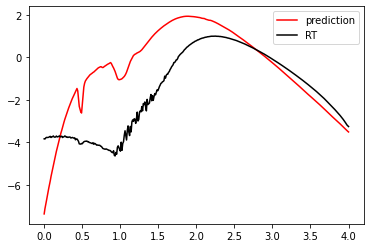

650
{'Tstar': 4454.403101871443, 'logL_star': -0.3498043067121439, 'logM_disk': -6.56785295288505, 'logR_disk': 1.569555204322567, 'h_0': 0.14070895057101784, 'logR_in': 1.0047295060595052, 'gamma': 1.6988321530342911, 'beta': 1.7735405610268318, 'logM_env': -5.426998417425889, 'logR_env': 3.234085226257028, 'f_cav': 0.9725899975778235, 'ksi': 0.8023284124721353, 'loga_max': 1.6058238688608648, 'p': 4.326270918412509, 'incl': 8.357413328436417, 'filename': 'Tstar_4454.403_logLstar_-0.350_logMdisk_-6.568_logRdisk_1.570_h0_0.141_logRin_1.005_gamma_1.699_beta_1.774_logMenv_-5.427_logRenv_3.234_fcav_0.973_ksi_0.802_logamax_1.606_p_4.326_incl_8.357.hdf5'}


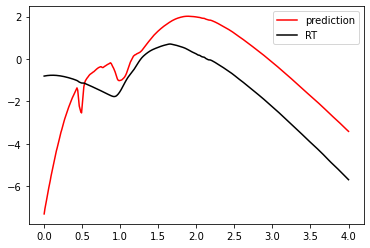

1874
{'Tstar': 3242.0406056769198, 'logL_star': 1.3622726463460775, 'logM_disk': -4.242577153001753, 'logR_disk': 2.5231343001682864, 'h_0': 0.17895971652040965, 'logR_in': 0.936998490639332, 'gamma': 0.06553047172656438, 'beta': 0.9856360105751454, 'logM_env': -2.7608080593085216, 'logR_env': 3.8251181779605976, 'f_cav': 0.7330494708156033, 'ksi': 1.0569127006822745, 'loga_max': 2.6735466073307617, 'p': 3.415353254386367, 'incl': 31.307346880644932, 'filename': 'Tstar_3242.041_logLstar_1.362_logMdisk_-4.243_logRdisk_2.523_h0_0.179_logRin_0.937_gamma_0.0_beta_0.986_logMenv_-2.761_logRenv_3.825_fcav_0.733_ksi_1.057_logamax_2.674_p_3.415_incl_31.307.hdf5'}


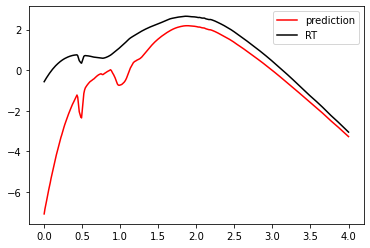

3005
{'Tstar': 4183.741605141453, 'logL_star': -0.06230402142101077, 'logM_disk': -2.845454277637222, 'logR_disk': 2.0969190601741223, 'h_0': 0.4263852303451669, 'logR_in': 0.10849140350787234, 'gamma': 0.7244755569061491, 'beta': 0.8151780301900542, 'logM_env': -2.189784306482654, 'logR_env': 3.81630912681511, 'f_cav': 0.9102321586276634, 'ksi': 1.2030164301827364, 'loga_max': 1.5076397885300086, 'p': 4.477287142860087, 'incl': 33.71048055653633, 'filename': 'Tstar_4183.742_logLstar_-0.062_logMdisk_-2.845_logRdisk_2.097_h0_0.426_logRin_0.108_gamma_0.724_beta_0.815_logMenv_-2.190_logRenv_3.816_fcav_0.910_ksi_1.203_logamax_1.508_p_4.477_incl_33.710.hdf5'}


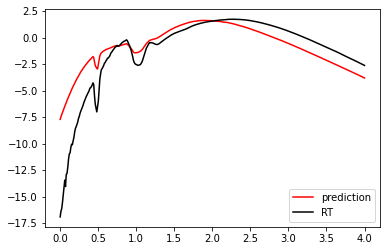

52
{'Tstar': 3664.314044462357, 'logL_star': -0.33884150004003466, 'logM_disk': -5.367421269423939, 'logR_disk': 0.843808357009623, 'h_0': 0.09314489537867995, 'logR_in': 0.10708715002428915, 'gamma': 0.5465433269860649, 'beta': 1.2003314737297175, 'logM_env': -7.3068070307121475, 'logR_env': 3.8258676523625255, 'f_cav': 0.22901763570052713, 'ksi': 1.0056187201124205, 'loga_max': 4.437206556425423, 'p': 2.812070901138101, 'incl': 42.67264120158319, 'filename': 'Tstar_34.314_logLstar_-0.339_logMdisk_-5.367_logRdisk_0.844_h0_0.093_logRin_0.107_gamma_0.547_beta_1.200_logMenv_-7.307_logRenv_3.826_fcav_0.229_ksi_1.006_logamax_4.437_p_2.812_incl_42.673.hdf5'}


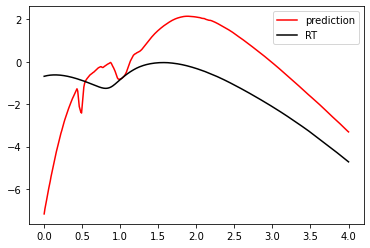

3555
{'Tstar': 4152.909784102462, 'logL_star': 1.7218423000177192, 'logM_disk': -4.5531902280935865, 'logR_disk': 2.000553508318008, 'h_0': 0.4221514655892955, 'logR_in': 0.9672837927214997, 'gamma': 1.8205688221651901, 'beta': 1.467016794263694, 'logM_env': -3.3842124867245946, 'logR_env': 2.7593154399446345, 'f_cav': 0.09924828790534998, 'ksi': 1.3843727005054984, 'loga_max': 3.6691600875858494, 'p': 3.4876727732186446, 'incl': 19.676779232054514, 'filename': 'Tstar_4152.910_logLstar_1.722_logMdisk_-4.553_logRdisk_2.001_h0_0.422_logRin_0.967_gamma_1.821_beta_1.467_logMenv_-3.384_logRenv_2.759_fcav_0.099_ksi_1.384_logamax_3.9_p_3.4_incl_19.677.hdf5'}


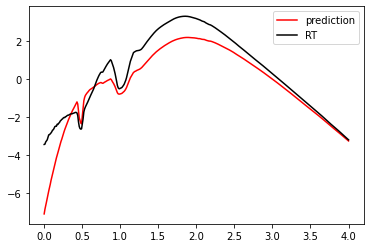

547
{'Tstar': 3091.772042810584, 'logL_star': 2.896672386856635, 'logM_disk': -5.260054209312449, 'logR_disk': 1.2594803250936757, 'h_0': 0.34852413399448406, 'logR_in': 1.0298523470453458, 'gamma': 1.431719012385682, 'beta': 1.8437256311377115, 'logM_env': -3.1343722300085464, 'logR_env': 2.7705138364422552, 'f_cav': 0.21296451977519745, 'ksi': 1.397276621131649, 'loga_max': 0.29357113076333785, 'p': 4.0368268293719325, 'incl': 67.28426203311514, 'filename': 'Tstar_3091.772_logLstar_2.897_logMdisk_-5.260_logRdisk_1.259_h0_0.349_logRin_1.030_gamma_1.432_beta_1.844_logMenv_-3.134_logRenv_2.771_fcav_0.213_ksi_1.397_logamax_0.294_p_4.037_incl_67.284.hdf5'}


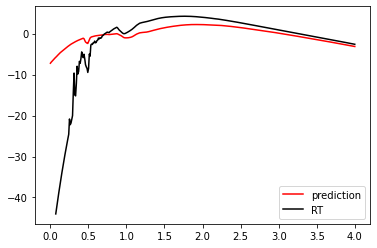

1014
{'Tstar': 4417.194026114285, 'logL_star': 0.30928227503126315, 'logM_disk': -2.409848808145364, 'logR_disk': 0.9853267526164712, 'h_0': 0.24447492262619228, 'logR_in': 0.35507135126505274, 'gamma': 1.7367381654105856, 'beta': 1.1981360805835115, 'logM_env': -3.2842996961234316, 'logR_env': 2.9629468217089268, 'f_cav': 0.7179487003494831, 'ksi': 1.337593306950063, 'loga_max': 3.1767822325628705, 'p': 3.3197864928977885, 'incl': 58.29427802958838, 'filename': 'Tstar_4417.194_logLstar_0.309_logMdisk_-2.410_logRdisk_0.985_h0_0.244_logRin_0.355_gamma_1.737_beta_1.198_logMenv_-3.284_logRenv_2.963_fcav_0.718_ksi_1.338_logamax_3.177_p_3.320_incl_58.294.hdf5'}


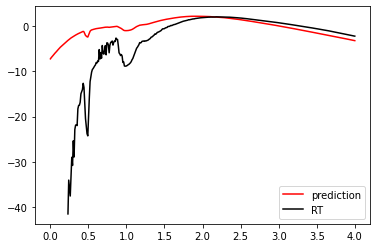

In [242]:
for i in range(len(predicted_SEDs)):
    print(sample[i])
    print(orig_dict[sample[i]])
    plt.plot(np.log10(xvals),predicted_SEDs[i],c='r',label="prediction")
    plt.plot(np.log10(xvals),point(sample[i])[1],c='k',label="RT")
    plt.legend()
    plt.show()

In [243]:
from sklearn.decomposition import PCA


# get all model data
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)[100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]

# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

done in 0.060s


In [244]:
ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]
steps=[]
bases=[]
for i in range(len(ranges)):
    steps.append(np.linspace(ranges[i][0],ranges[i][1],11))
    bases.append(steps[i][5])

# slices - read in filenames and logspace flux values
with open ('../grid_metadata/slicenames.txt', 'rb') as fp:
    slicenames = pickle.load(fp)
with open ('../grid_metadata/slicevals.txt', 'rb') as fp:
    slicevals = pickle.load(fp)[:,:,100:500]
with open ('../grid_metadata/slicevals.txt', 'rb') as fp:
    nanslicevals = pickle.load(fp)[:,:,100:500]

# fix -infs: powerlaw cutoff
for i in range(len(slicevals)):
    for j in range(len(slicevals[i])):
        if -np.inf in slicevals[i][j]:
            a = slicevals[i][j].tolist()
            a.reverse()
            ind = len(a)-a.index(-np.inf)
            x1 = xvals[ind]
            y1 = slicevals[i][j][ind]
            for m in range(ind):
                slicevals[i][j][m]=(100*(np.log10(xvals[m]/x1)))+y1
                
nanslicevals[nanslicevals<-20]=np.nan

slice_seds_msub = slicevals - np.nanmean(nanslicevals,axis=2)[:,:,np.newaxis]

In [245]:
fitdata=[]

for i in range(len(param_names)):
    fitdata.append([])
for i in range(len(param_names)):
    for j in range(11):
        modeldata=[]
        paramval=steps[i][j]
        coeffs=pca.transform(slice_seds_msub[i][j].reshape(1,-1))
        modeldata.append(paramval)
        for k in range(10):
            modeldata.append(coeffs[0][k])
        fitdata[i].append(modeldata)

In [246]:
paramvals=[]
weights=[]
for param in range(15):
    pl=[]
    wl=[]
    for model in range(11):
        pl.append(fitdata[param][model][0])
    paramvals.append(pl)
    
    for w in range(10):
        wsl=[]
        for model in range(11):
            wsl.append(fitdata[param][model][w+1])
        wl.append(wsl)
    weights.append(wl)

In [252]:
np.array(paramvals).shape

(15, 11)

In [247]:
def load_pcwpar(param,weight):
    return np.array(paramvals[param]).reshape(-1,1), np.array(weights[param][weight])

In [249]:
aX

array([[-1. ],
       [-0.6],
       [-0.2],
       [ 0.2],
       [ 0.6],
       [ 1. ],
       [ 1.4],
       [ 1.8],
       [ 2.2],
       [ 2.6],
       [ 3. ]])

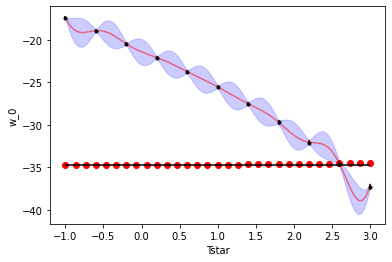

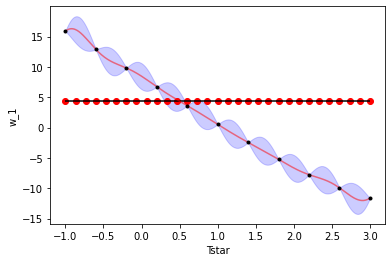

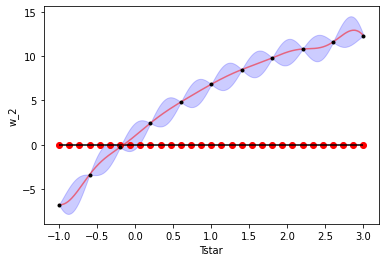

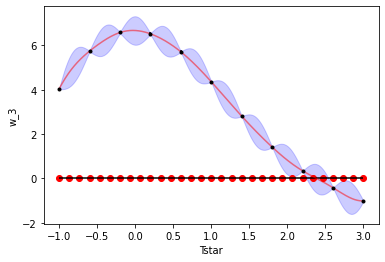

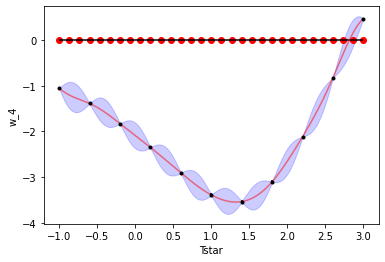

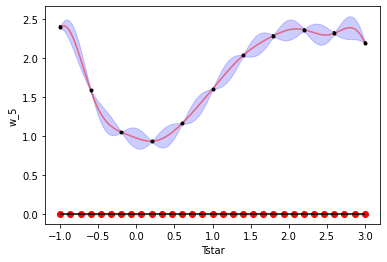

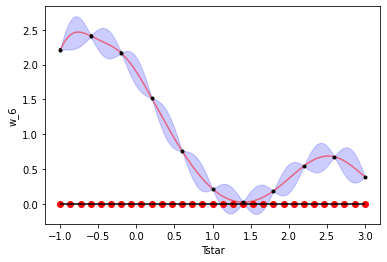

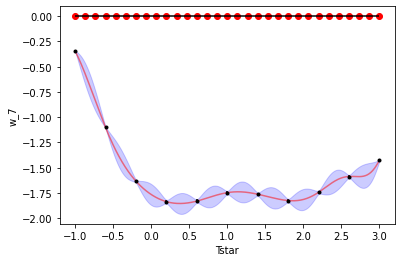

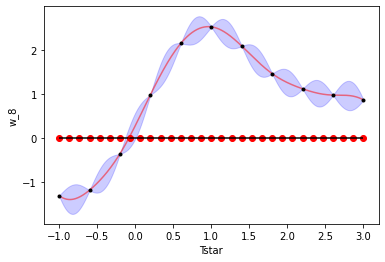

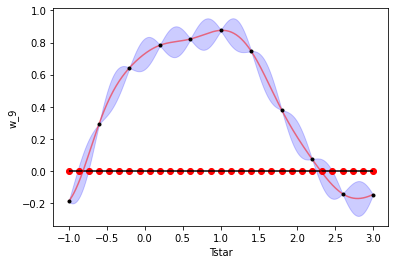

IndexError: list index out of range

In [248]:
for i in range(15):
    aX, ay = load_pcwpar(1,i)
    ayerr=[j*0.01 for j in ay]

    akernel = kernels.ExpSquaredKernel(.3**2) * np.var(ay)

    agp = george.GP(akernel)
    agp.compute(aX,ayerr)

    ax_pred = np.linspace(-1,3,500)
    apred, apred_var = agp.predict(ay, ax_pred, return_var=True)

    plt.fill_between(ax_pred, apred - np.sqrt(apred_var), apred + np.sqrt(apred_var),
                    color="b", alpha=0.2)
    plt.plot(ax_pred, apred, "r", lw=1.5, alpha=0.5)
    plt.xlabel("logL_star")
    plt.ylabel("w_"+str(i))
    plt.scatter(np.array(slicepoints)[:,1],slice_weights[i],c='r')
    plt.hlines(slice_weights[i][0],xmin=ranges[1][0],xmax=ranges[1][1])
    plt.errorbar(aX, ay, ayerr,fmt=".k", capsize=0)
    plt.show()

In [173]:
slicepoints=[]
for i in range(31):
    point=[]
    for j in range(len(bases)):
        if j!=1:
            point.append(bases[j])
        else:
            point.append(ranges[1][0]+(i/30)*(ranges[1][1]-ranges[1][0]))
    slicepoints.append(point)

In [195]:
slice_SEDs, slice_weights =pred(slicepoints)